In [80]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join as oj
import os
import numpy as np
from imodels import RuleListClassifier, RuleFit, SLIM, GreedyRuleList, SkopeRules, IRFClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import data
import validate
outcome_def = 'iai_intervention' # output
MODELS_DIR = '../models/simple'
os.makedirs(MODELS_DIR, exist_ok=True)


# set up data
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

train_idxs = df.cv_fold.isin(data.pecarn_train_idxs)
test_idxs1 = df.cv_fold.isin(data.pecarn_test_idxs)
test_idxs2 = df.cv_fold.isin(data.psrc_train_idxs + data.psrc_test_idxs)

X, y = df[processed_feats], df[outcome_def]
half = train_idxs.sum() // 2
X_train, y_train = X[train_idxs][:half], y[train_idxs][:half]
X_cv, y_cv = X[train_idxs][half:], y[train_idxs][half:]
X_test1, y_test1 = X[test_idxs1], y[test_idxs1]
X_test2, y_test2 = X[test_idxs2], y[test_idxs2]


def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_test1, X_test2, X_cv], [y_train, y_test1, y_test2, y_cv], ['_train', '_test1', '_test2', '_cv']):
        sens, spec, threshes = validate.sensitivity_specificity_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_cv')
        results['sens' + suffix] = sens
        results['spec' + suffix] = spec
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))        
    return sens, spec, threshes

  0%|          | 0/49 [00:00<?, ?it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
read all the csvs...


100%|██████████| 49/49 [00:01<00:00, 40.81it/s]
0it [00:00, ?it/s]

merge all the dfs...


48it [00:18,  1.52it/s]


# fit simple models

**decision tree**

100%|██████████| 8/8 [00:00<00:00, 133.66it/s]


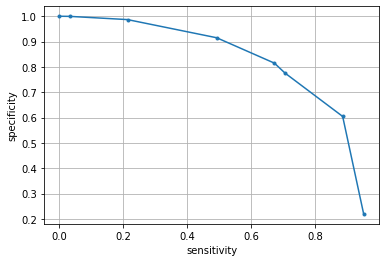

In [81]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(dt, model_name='decision_tree')

# visualize
# plt.figure(dpi=300)
# plot_tree(dt, feature_names=processed_feats, impurity=False, filled=True)
# plt.savefig('tree.pdf')
plt.show()

**bayesian rule lists**

training bayesian_rule_list...


100%|██████████| 6/6 [00:00<00:00, 147.20it/s]


Trained RuleListClassifier for detecting IwI
IF DecrBreathSound_yes : 0.5_to_inf THEN probability of IwI: 13.9% (7.9%-21.2%)
ELSE IF GCSScore_Full_yes : 0.5_to_inf AND AbdTrauma_or_SeatBeltSign_yes : -inf_to_0.5 THEN probability of IwI: 0.3% (0.1%-0.6%)
ELSE IF Hypotension_yes : 0.5_to_inf THEN probability of IwI: 33.3% (18.6%-50.0%)
ELSE IF AbdTrauma_or_SeatBeltSign_yes : -inf_to_0.5 THEN probability of IwI: 3.0% (1.6%-4.8%)
ELSE IF GCSScore_Full_yes : 0.5_to_inf THEN probability of IwI: 3.5% (2.1%-5.3%)
ELSE probability of IwI: 19.1% (10.8%-29.2%)



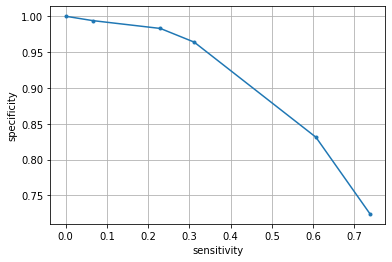

In [82]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = RuleListClassifier(max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_labels=processed_feats)
sens, spec, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

**rulefit**

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013306191744764106, tolerance: 0.004906050357008647
  tol, rng, random, positive)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006022177192544831, tolerance: 0.004906050357008647
  tol, rng, random, positive)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005952266120296201, tolerance: 0.004906050357008647
  tol, rng, random, positive)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_

                                                  rule  type      coef  \
164  AbdDistention_or_AbdomenPain_yes <= 0.5 & Hypo...  rule -0.003539   
659  Hypotension_yes <= 0.5 & DecrBreathSound_yes <...  rule -0.002574   
326  Hypotension_yes <= 0.5 & DecrBreathSound_yes <...  rule -0.012979   
201  AbdDistention_or_AbdomenPain_yes <= 0.5 & Hypo...  rule -0.000293   
463  GCSScore_Full_yes > 0.5 & DecrBreathSound_yes ...  rule -0.034407   
349  GCSScore_Full_yes > 0.5 & Hypotension_yes <= 0...  rule -0.002556   
586  Hypotension_yes <= 0.5 & DecrBreathSound_yes <...  rule -0.026273   
80   Hypotension_yes <= 0.5 & ThoracicTrauma_yes <=...  rule -0.009761   
733  Hypotension_yes <= 0.5 & MOI_Motor vehicle col...  rule -0.000669   
459  Hypotension_yes <= 0.5 & DecrBreathSound_yes <...  rule -0.007530   
730  AbdTrauma_or_SeatBeltSign_yes > 0.5 & GCSScore...  rule  0.021917   

      support  importance  
164  0.931106    0.000896  
659  0.876827    0.000846  
326  0.870564    0.004357  

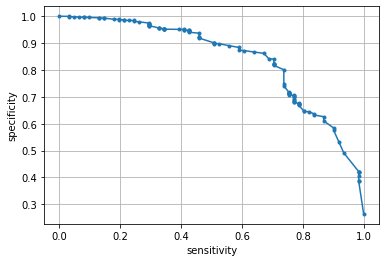

In [83]:
# fit a rulefit model
np.random.seed(13)
rulefit = RuleFit()
rulefit.fit(X_train, y_train, feature_names=processed_feats)

# preds = rulefit.predict(X_test)
sens, spec, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''
# print(sklearn.metrics.classification_report(y_test, preds))
rules = rulefit.get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
print(rules)

**slim**

In [ ]:
fewest_feats = data.fewest_feats
CLASS_WEIGHT = 100
n = X_train.shape[0]
lambda_reg = 10

# optionally upweight positive samples
sample_weight = np.ones((n))
sample_weight[y_train[:n] == 1] *= CLASS_WEIGHT
sample_weight /= sample_weight.max()

# fit
X_train_small = X_train[fewest_feats]
slim = SLIM()
slim.fit(X_train_small[:n], y_train[:n] * 100, lambda_reg=lambda_reg,
         sample_weight=sample_weight)

# calculate mse on the training data
# sens, spec, threshes = predict_and_save(slim, model_name='slim')

X_test_small = X_test1[fewest_feats]
# preds = slim.predict(X_test_small)
# preds_proba = [1 / (1 + np.exp(-y)) for y in preds]
preds_proba = slim.predict_proba(X_test_small)
print('considered ', len(fewest_feats), 'feats')
coefs = slim.model.coef_.astype(int)
intercept = slim.model.intercept_
for i in range(len(fewest_feats)):
    if coefs[i] != 0:
        print(fewest_feats[i], coefs[i])
print('intercept', intercept)

100%|██████████| 11/11 [00:00<00:00, 142.31it/s]


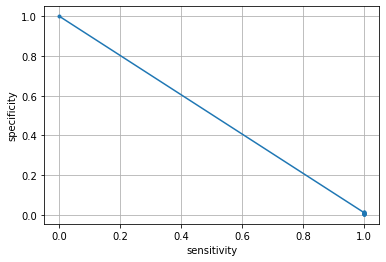

In [85]:
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test1, preds_proba[:, 1], plot=True)

**skope rules**

  0%|          | 0/16 [00:00<?, ?it/s]

Rules for iai
('AbdTrauma_or_SeatBeltSign_yes > 0.5 and DecrBreathSound_yes <= 0.5 and GCSScore_Full_yes <= 0.5', (0.2115646821456156, 0.2006389561474307, 3))
('DecrBreathSound_yes <= 0.5 and GCSScore_Full_yes <= 0.5 and Hypotension_yes > 0.5', (0.37468671679197996, 0.13157894736842105, 2))
('AbdTrauma_or_SeatBeltSign_yes > 0.5 and GCSScore_Full_yes <= 0.5 and Hypotension_yes <= 0.5', (0.1927533378610186, 0.1945678746381923, 162))
('MOI_Pedestrian/bicyclist struck by moving vehicle <= 0.5 and GCSScore_Full_yes <= 0.5 and Hypotension_yes > 0.5', (0.4157952069716776, 0.12529627235509588, 3))
('CostalTender_yes <= 0.5 and GCSScore_Full_yes <= 0.5 and Hypotension_yes > 0.5', (0.3342297854265669, 0.12639689545320099, 101))
('ThoracicTrauma_yes <= 0.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5 and GCSScore_Full_yes <= 0.5', (0.27586206896551724, 0.13333333333333333, 1))
('ThoracicTrauma_yes > 0.5 and Hypotension_yes > 0.5 and MOI_Fall from an elevation <= 0.5', (0.5, 0.10714285714285714, 1))
('

100%|██████████| 15/15 [00:00<00:00, 148.90it/s]


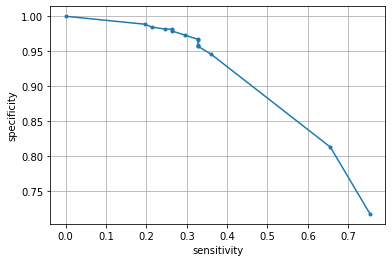

In [86]:
# feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
clf = SkopeRules(max_depth_duplication=100,
                 n_estimators=100,
                 precision_min=0.01, # per rule precision min
                 recall_min=0.1,     # per rule recall min
                 feature_names=processed_feats)
clf.fit(X_train, y_train)
# print the rules
rules = clf.rules_
print("Rules for iai")
for rule in rules:
    print(rule)

# evaluate
sens, spec, threshes = predict_and_save(clf, model_name='skope')

plt.show()

**greedy rule list**

In [ ]:
class_weight = {0: 1, 1: 100}
d = GreedyRuleList(max_depth=7, class_weight=class_weight, criterion='gini')
d.fit(X_train, y_train, verbose=True)

In [ ]:
sens, spec, threshes = predict_and_save(d, model_name='grl')
d.print_list()

100%|██████████| 163/163 [00:01<00:00, 145.76it/s]


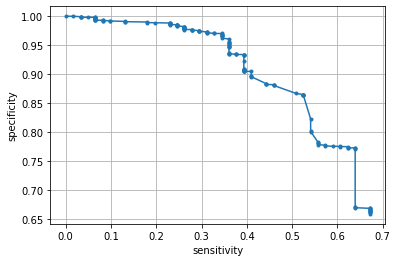

In [89]:
# specify a decision tree with a maximum depth
irf = IRFClassifier()
irf.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(irf, model_name='irf')
# sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)

In [ ]:
# specify a decision tree with a maximum depth
irf = IRFClassifier()
irf.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(irf, model_name='irf')
# sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)

In [90]:
imps = irf.model.feature_importances_.round(3) * 100
args = np.argsort(imps)
imps = imps[args]
feats = np.array(processed_feats)[args]
for imp, feat in zip(imps, feats):
    print(feat, imp)

MOI_Bike collision/fall 2.0
MOI_Motorcycle/ATV/Scooter collision 2.8000000000000003
AbdDistention_or_AbdomenPain_yes 3.0
MOI_Object struck abdomen 3.2
MOI_Fall from an elevation 3.6999999999999997
MOI_Pedestrian/bicyclist struck by moving vehicle 3.8
Age<2_yes 5.1
AbdTenderDegree_None 7.3
AbdTrauma_or_SeatBeltSign_yes 7.3999999999999995
DecrBreathSound_yes 7.3999999999999995
MOI_Motor vehicle collision 7.3999999999999995
VomitWretch_yes 8.5
CostalTender_yes 8.7
ThoracicTrauma_yes 9.8
Hypotension_yes 9.9
GCSScore_Full_yes 10.0


# look at all the results

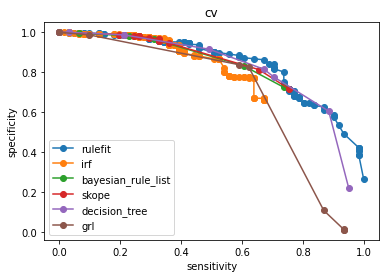

In [91]:
suffix = '_cv' # _test1, _test2, _cv
for fname in os.listdir(MODELS_DIR):
    if 'pkl' in fname:
        r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
#         print(r)
        sens = r['sens' + suffix]
        spec = r['spec' + suffix]
        plt.plot(sens, spec, 'o-', label=fname[:-4])
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.title(suffix[1:])
plt.legend()

In [92]:
data_sizes = {
    'train': (y_train.sum(), X_train.shape[0]),
    'cv': (y_cv.sum(), X_cv.shape[0]),
    'test1': (y_test1.sum(), X_test1.shape[0]),
    'test2': (y_test2.sum(), X_test2.shape[0]),
}     
data_sizes

{'train': (72, 3992),
 'cv': (61, 3993),
 'test1': (70, 4059),
 'test2': (62, 2188)}

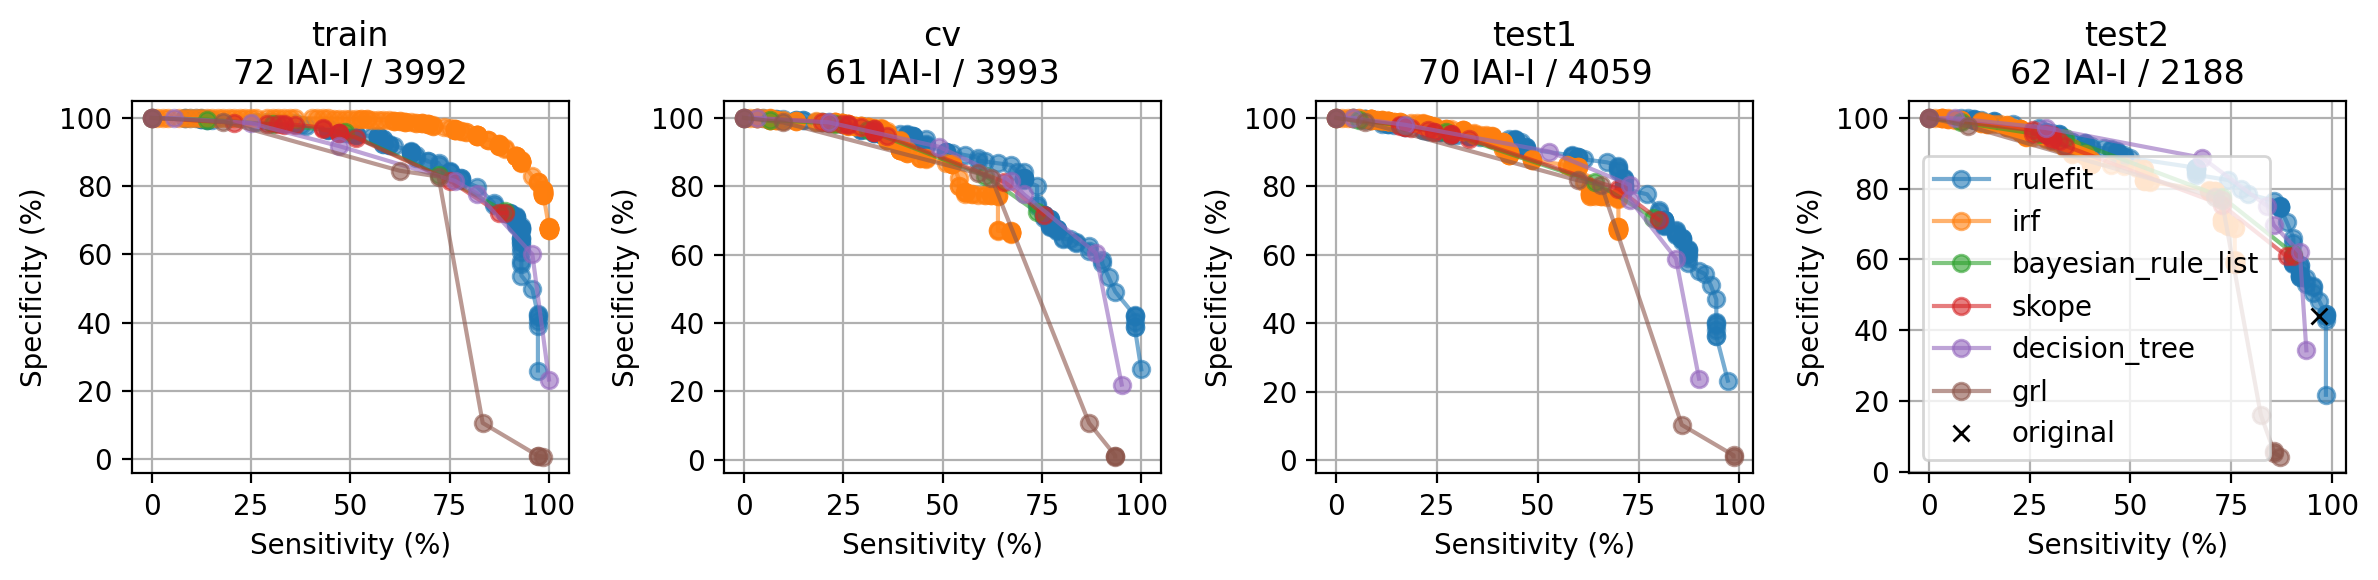

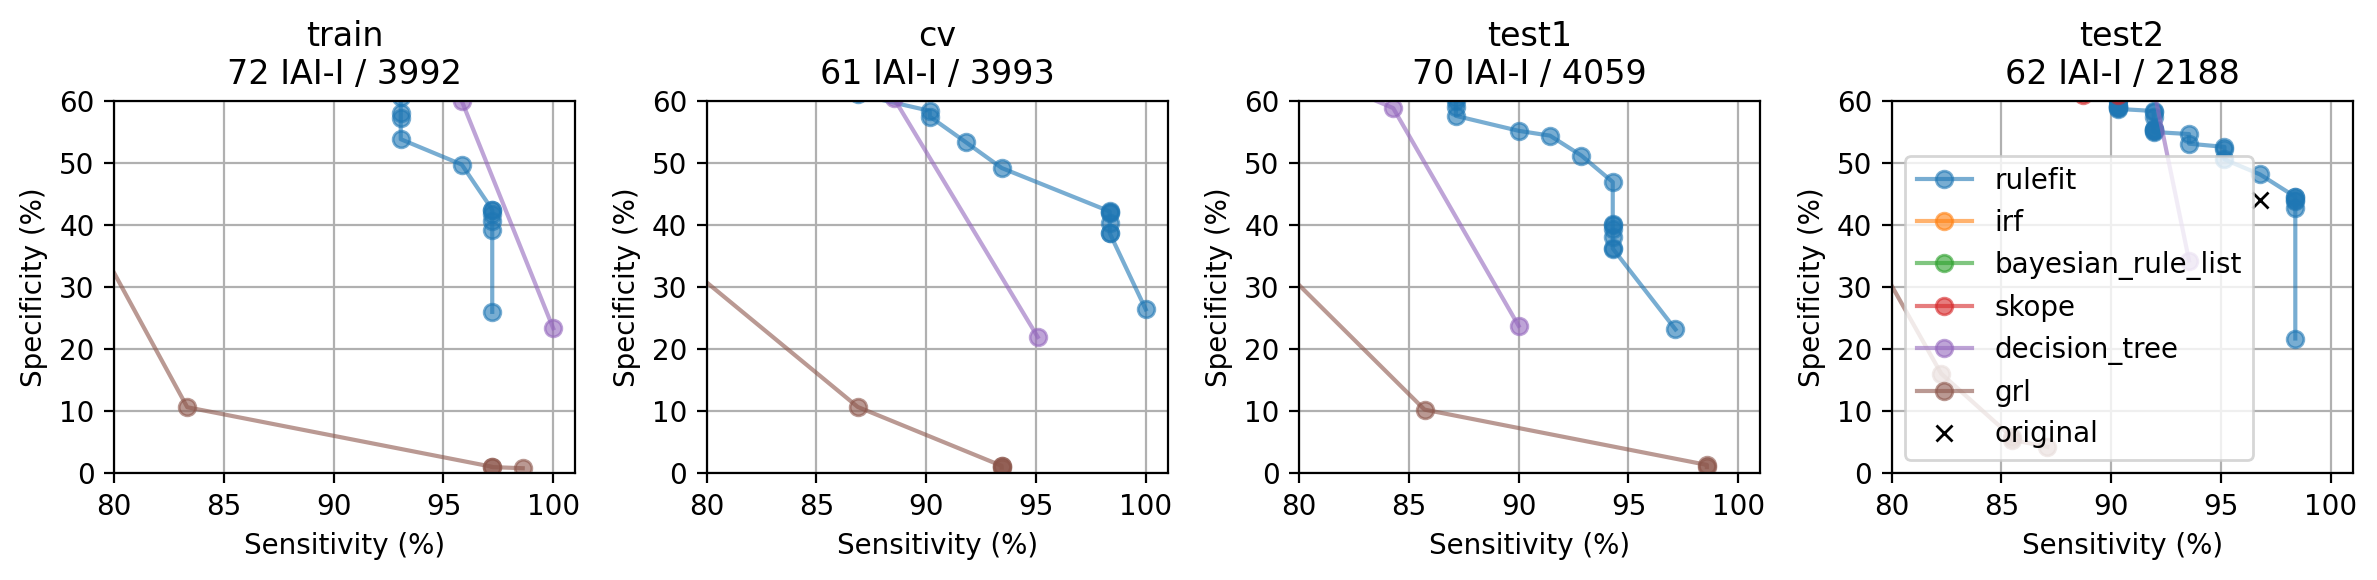

In [93]:
def plot_metrics(suffix):
    for fname in os.listdir(MODELS_DIR):
        if 'pkl' in fname:
            r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
    #         print(r)
            sens = np.array(r['sens' + suffix])
            spec = np.array(r['spec' + suffix])
            plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6)
            plt.xlabel('Sensitivity (%)')
            plt.ylabel('Specificity (%)')
            s = suffix[1:]
            plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'x', color='black', label='original')
    plt.grid()
#     plt.legend()



suffixes = ['_train', '_cv', '_test1', '_test2'] # _test1, _test2, _cv    
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, suffix in enumerate(suffixes):
    plt.subplot(R, C, i + 1)
    plot_metrics(suffix)
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, suffix in enumerate(suffixes):
    plt.subplot(R, C, i + 1)
    plot_metrics(suffix)
    plt.xlim((80, 101))
    plt.ylim((0, 60))
plt.legend()
plt.tight_layout()
plt.show()